<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/src/Data_Loader_NeuronBlocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploratory Data Analysis of Stringer Dataset 
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

# to do list

1. custom normalization: dividing by mean value per neuron
1a. downsampling: convolve then downsample by 5
2. training validation split: withhold last 20 percent of time series for testing
3. RNN for each layer: a way to capture the dynamics inside each layer instead of capturing extra dynamics from inter-layer interactions. it will be OK to compare the different RNNs. maintain same neuron count in each layer to reduce potential bias 
4. layer weight regularization: L2 
5. early stopping , dropout?

## Loading of Stringer spontaneous data



In [2]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [4]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [5]:
# functions 

def moving_avg(array, factor = 5):
  """Reducing the number of compontents by averaging of N = factor
  subsequent elements of array"""
  zeros_ = np.zeros((array.shape[0], 2))
  array = np.hstack((array, zeros_))

  array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor))
  array = np.mean(array, axis = 2)

  return array

## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [6]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [19]:

resp = np.array(dat['sresp'])
xyz = np.array(dat['xyz'])
print(resp.shape, xyz[0].shape)

(11983, 7018) (11983,)


In [87]:
# Extracting x,y blocks

n_blocks = 9

x_range, y_range, _ = np.ptp(dat['xyz'], axis = 1)

x_block_starts = np.arange(min(x), max(x), x_range // (n_blocks ** 0.5))
y_block_starts = np.arange(min(y), max(y), y_range // (n_blocks ** 0.5))

data_blocks = list()

for i in range(int(n_blocks ** 0.5)):
  for k in range(int(n_blocks ** 0.5)):
    tempx, = np.where((x >= x_block_starts[0]) & (x <= x_block_starts[1]))
    tempy, = np.where((y >= y_block_starts[0]) & (y <= y_block_starts[1]))
    idx = np.intersect1d(tempx, tempy)
    data_blocks.append(resp[idx])


data_blocks = np.array(data_blocks)

data_blocks.shape





(9, 1314, 7018)

In [132]:
1314 * 9 # roughly 200 neurons are lost at the boundary 

11826

In [91]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [92]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
  data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1])

dataRNN = np.zeros((n_samples*9, dataSet.shape[1]-1))
for i in range(0,9):
  dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]

## shuffling for training purposes

#np.random.shuffle(dataRNN)

(10179, 7018)


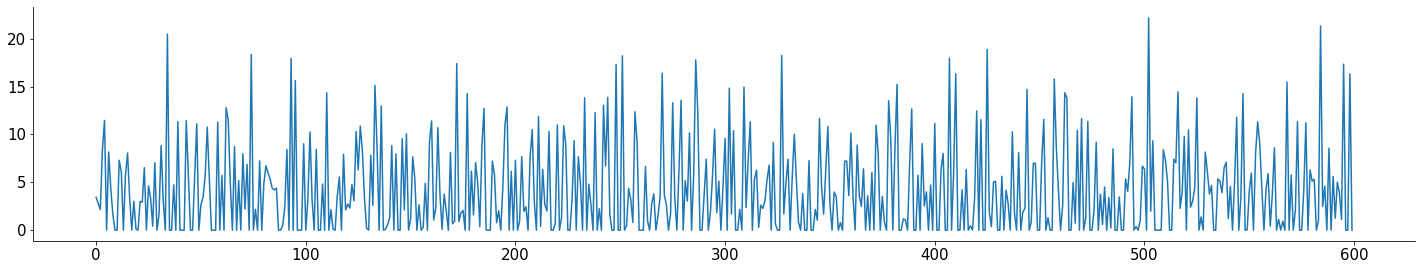

In [93]:
plt.plot(dataRNN[0, :600])
print(dataRNN.shape)

In [139]:
#@title PCA 

from sklearn.decomposition import PCA

#pca developed seperately for blocks and layers. note: the number of neurons and timepoints are constrained

block_pca = PCA(n_components = 500)
block_pca = block_pca.fit(data_blocks[0,:1131,:600].T)
compress_blocks = block_pca.transform(data_blocks[0,:1131,:1200].T)

print(compress_blocks.shape)

layer_pca = PCA(n_components = 500)
layer_pca = layer_pca.fit(dataRNN[:1131,:600].T)
compress_layers = layer_pca.transform(dataRNN[:1131,:1200].T)

print(compress_layers.shape)

(1200, 500)
(1200, 500)


0.74739975 0.6650082930536177


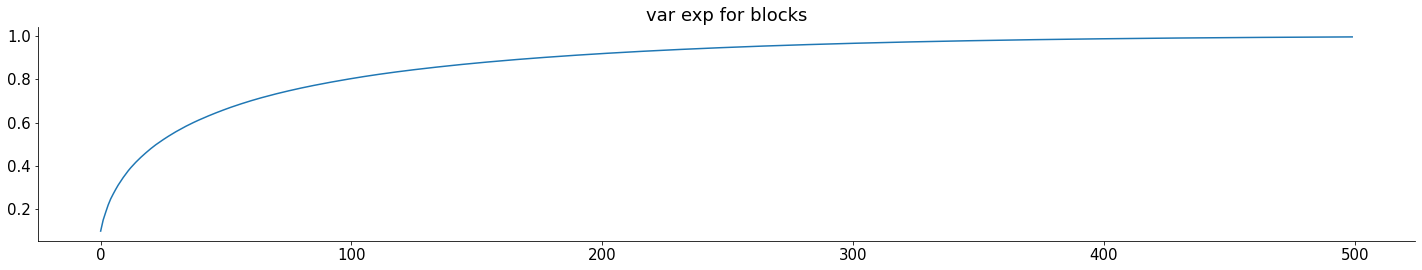

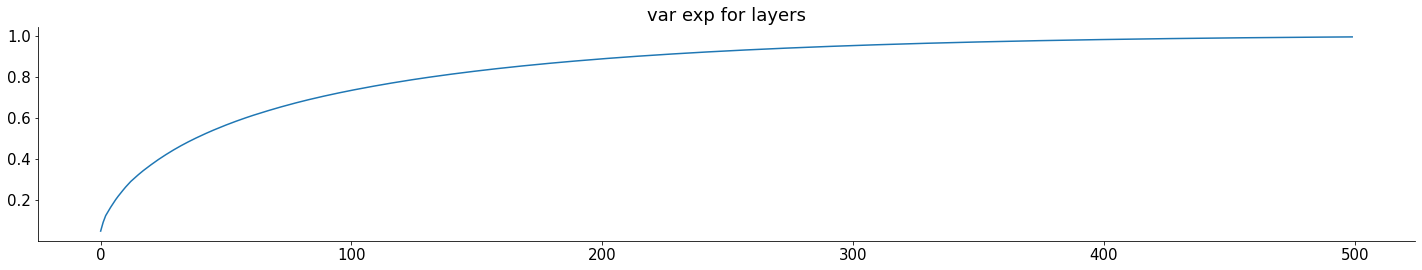

In [141]:
var_block = np.cumsum(pca.explained_variance_ratio_)
var_layer = np.cumsum(pca2.explained_variance_ratio_)

plt.plot(var_block)
plt.title('var exp for blocks')
plt.figure()
plt.plot(var_layer)
plt.title('var exp for layers')


print(var_block[75], var_layer[75])





In [ ]:
unshuffled = np.array(data_)

In [ ]:
#@title Convolutions code

# convolution moving average

# kernel_length = 50
# averaging_kernel = np.ones(kernel_length) / kernel_length

# dataRNN.shape

# avgd_dataRNN = list()

# for neuron in dataRNN:
#   avgd_dataRNN.append(np.convolve(neuron, averaging_kernel))

# avg_dataRNN = np.array(avgd_dataRNN)

# print(avg_dataRNN.shape)

In [ ]:
# @title Z Score Code 


# from scipy.stats import zscore


# neuron = 500

# scaled_all = zscore(avg_dataRNN)
# scaled_per_neuron = zscore(avg_dataRNN[neuron, :])

# scaled_per_layer = list()

# for layer in unshuffled:
#   scaled_per_layer.append(zscore(layer))

# scaled_per_layer = np.array(scaled_per_layer)



# plt.plot(avg_dataRNN[neuron, :])
# plt.plot(avg_dataRNN[2500, :])
# plt.figure()
# plt.plot(dataRNN[neuron, :])
# plt.figure()
# plt.plot(scaled_all[neuron, :])
# plt.plot(scaled_per_neuron)
# plt.figure()
# plt.plot(scaled_per_layer[0,neuron,:])


In [32]:
# custom normalization

normed_dataRNN = list()
for neuron in dataRNN:
  normed_dataRNN.append(neuron / neuron.mean())
normed_dataRNN = np.array(normed_dataRNN)

# downsampling and averaging 

avgd_normed_dataRNN = moving_avg(normed_dataRNN, factor=5)

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

# let's use 270 latent components
ncomp = 10

In [ ]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(1404, 10179)

In [ ]:
frac = 5/6
#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
x1 = torch.from_numpy(avgd_normed_dataRNN[:,:50]).to(device).float().unsqueeze(0)
x2 = torch.from_numpy(avgd_normed_dataRNN[:,:50]).to(device).float().unsqueeze(0)

NN1 = x1.shape[-1]
NN2 = x2.shape[-1]

In [ ]:
class Net(nn.Module):
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.fc = nn.Linear(ncomp, NN2)

  def forward(self, x):

    y = self.rnn(x)[0]

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    #z = F.softplus(self.fc(q), 10)
    z = self.fc(q)

    return z, q

In [ ]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = x1.mean(axis = (1,2))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net.parameters(), lr=.02)

In [ ]:
# forward check 
# net(x1)

## Training 

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

niter = 100000
for k in tqdm(range(niter)):
  # the network outputs the single-neuron prediction and the latents
  z, y = net(x1)

  # our cost
  loss = cost(z, x2)

  # train the network as usual
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  if k % 250 == 0:
    print(f' iteration {k}, cost {loss.item():.4f}')

 iteration 0, cost 0.2433
 iteration 250, cost 0.2435
 iteration 500, cost 0.2439
 iteration 750, cost 0.2459
 iteration 1000, cost 0.2431
 iteration 1250, cost 0.2430
 iteration 1500, cost 0.2431
 iteration 1750, cost 0.2435
 iteration 2000, cost 0.2428
 iteration 2250, cost 0.2430
 iteration 2500, cost 0.2435
 iteration 2750, cost 0.2431
 iteration 3000, cost 0.2430
 iteration 3250, cost 0.2447
 iteration 3500, cost 0.2439
 iteration 3750, cost 0.2442
 iteration 4000, cost 0.2466
 iteration 4250, cost 0.2431
 iteration 4500, cost 0.2443
 iteration 4750, cost 0.2438
 iteration 5000, cost 0.2429
 iteration 5250, cost 0.2432
 iteration 5500, cost 0.2445
 iteration 5750, cost 0.2432
 iteration 6000, cost 0.2440
 iteration 6250, cost 0.2431
 iteration 6500, cost 0.2449
 iteration 6750, cost 0.2428
 iteration 7000, cost 0.2429
 iteration 7250, cost 0.2430
 iteration 7500, cost 0.2429
 iteration 7750, cost 0.2456
 iteration 8000, cost 0.2434
 iteration 8250, cost 0.2429
 iteration 8500, cos

KeyboardInterrupt: ignored

In [ ]:
test = net()